## **Preparing for H2N2**

# Business Understanding

As doctors and public health specialists warn of the forthcoming widespread of H2N2 flu virus, there is a rush from all pharmaceutical companies to develop the first H2N2 vaccine.  Once the vaccine is produced, the Department of Health and Human Services will run a public health campaign to encourage all eligible people recieve the vaccination.  The task is to run a predictive analysis on available data to inform that public health campaign - tailoring the campaign to specific demographics.

# Data Understanding

Data provided by the United States National Center for Health Statistics shows the social, economic, and demographic background of a surveyed population along with their opinions on effectiveness of vaccines and the vaccination status.  About 26,700 records were optained in the survey.



In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [31]:
vaccines = pd.read_csv('H1N1_Flu_Vaccines.csv')
vaccines.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Data Preparation

While the data includes information on both the H1N1 vaccine and the Seasonal Flu vaccine, we will concentrate on the H1N1 vaccination.  The H1N1 flu virus was first detected in spring 2009 and the vaccination was available in October 2009.  H1N1 came on quick, was unheard of and was responsible for many deaths.  As we expect H2N2 to be similar, we will predict that people react the same.

In [32]:
# concentrating on H1N1 vacccinations, we removed all columns concentrating on seasonal flu vaccines
flu_info = ['seasonal_vaccine', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
vaccines = vaccines.drop(flu_info, axis=1)
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [33]:
vaccines.isnull().sum()

,0
respondent_id,0
h1n1_concern,92
h1n1_knowledge,116
behavioral_antiviral_meds,71
behavioral_avoidance,208
behavioral_face_mask,19
behavioral_wash_hands,42
behavioral_large_gatherings,87
behavioral_outside_home,82
behavioral_touch_face,128


In [34]:
vaccines['opinion_h1n1_vacc_effective'].fillna(vaccines['opinion_h1n1_vacc_effective'].median(), inplace=True)
vaccines['opinion_h1n1_risk'].fillna(vaccines['opinion_h1n1_risk'].median(), inplace=True)
vaccines['opinion_h1n1_sick_from_vacc'].fillna(vaccines['opinion_h1n1_sick_from_vacc'].median(), inplace=True)

# Exploratory Data Analysis

In [35]:
print('1 = Not at all effective; 2 = Not very effective; 3 = Dont know; 4 = Somewhat effective; 5 = Very effective.')
print(vaccines['opinion_h1n1_vacc_effective'].value_counts().sort_index())
print('1 = Very Low; 2 = Somewhat low; 3 = Dont know; 4 = Somewhat high; 5 = Very high.')
print(vaccines['opinion_h1n1_risk'].value_counts().sort_index())
print('1 = Not at all worried; 2 = Not very worried; 3 = Dont know; 4 = Somewhat worried; 5 = Very worried.')
print(vaccines['opinion_h1n1_sick_from_vacc'].value_counts().sort_index())

1 = Not at all effective; 2 = Not very effective; 3 = Dont know; 4 = Somewhat effective; 5 = Very effective.
opinion_h1n1_vacc_effective
1.0      886
2.0     1858
3.0     4723
4.0    12074
5.0     7166
Name: count, dtype: int64
1 = Very Low; 2 = Somewhat low; 3 = Dont know; 4 = Somewhat high; 5 = Very high.
opinion_h1n1_risk
1.0     8139
2.0    10307
3.0     1117
4.0     5394
5.0     1750
Name: count, dtype: int64
1 = Not at all worried; 2 = Not very worried; 3 = Dont know; 4 = Somewhat worried; 5 = Very worried.
opinion_h1n1_sick_from_vacc
1.0    8998
2.0    9524
3.0     148
4.0    5850
5.0    2187
Name: count, dtype: int64


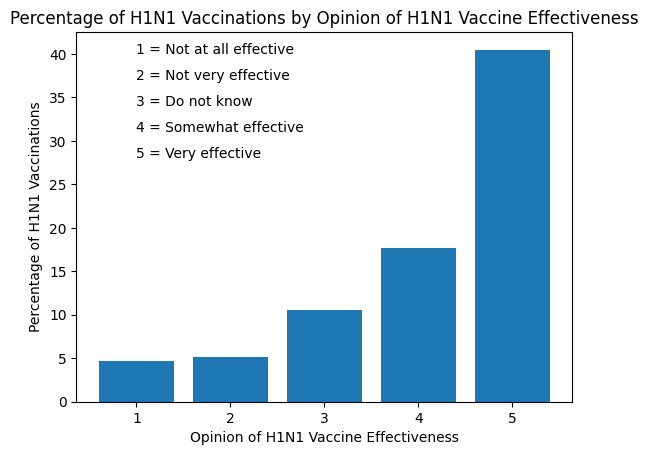

In [36]:
effective_percentages = vaccines.groupby('opinion_h1n1_vacc_effective')['h1n1_vaccine'].mean() * 100
plt.bar(effective_percentages.index, effective_percentages.values)
plt.xlabel('Opinion of H1N1 Vaccine Effectiveness')
plt.xlabel('Opinion of H1N1 Vaccine Effectiveness')
plt.ylabel('Percentage of H1N1 Vaccinations')
plt.title('Percentage of H1N1 Vaccinations by Opinion of H1N1 Vaccine Effectiveness')
plt.text(1,40, '1 = Not at all effective', fontsize=10)
plt.text(1,37, '2 = Not very effective', fontsize=10)
plt.text(1,34, '3 = Do not know', fontsize=10)
plt.text(1,31, '4 = Somewhat effective', fontsize=10)
plt.text(1,28, '5 = Very effective', fontsize=10)
plt.show()


In [37]:
results = sm.OLS(vaccines['h1n1_vaccine'], vaccines['opinion_h1n1_vacc_effective']).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           h1n1_vaccine   R-squared (uncentered):                   0.256
Model:                            OLS   Adj. R-squared (uncentered):              0.256
Method:                 Least Squares   F-statistic:                              9179.
Date:                Fri, 06 Jun 2025   Prob (F-statistic):                        0.00
Time:                        02:26:52   Log-Likelihood:                         -13266.
No. Observations:               26707   AIC:                                  2.653e+04
Df Residuals:                   26706   BIC:                                  2.654e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
opinion_h1n1_vacc_effective     0.0586      0.001     95.807      0.000       0.057       0.060
==============================================================================
Omnibus:                     4870.705   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8176.948
Skew:                           1.355   Prob(JB):                         0.00
Kurtosis:                       2.946   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
vaccines_demo = vaccines[['respondent_id','h1n1_vaccine','age_group','education','income_poverty','sex','race']]
vaccines_behavior = vaccines[['respondent_id','h1n1_vaccine','behavioral_antiviral_meds','behavioral_avoidance','behavioral_face_mask','behavioral_wash_hands','behavioral_large_gatherings','behavioral_outside_home','behavioral_touch_face']]

In [39]:
imputer_frequent = SimpleImputer(strategy='most_frequent')
vaccines_demo = pd.DataFrame(imputer_frequent.fit_transform(vaccines_demo), columns=vaccines_demo.columns)
vaccines_demo['h1n1_vaccine'] = vaccines_demo['h1n1_vaccine'].astype(int)

imputer_median = SimpleImputer(strategy='median')
vaccines_behavior = pd.DataFrame(imputer_median.fit_transform(vaccines_behavior), columns=vaccines_behavior.columns)
vaccines_behavior['h1n1_vaccine'] = vaccines_behavior['h1n1_vaccine'].astype(int)

In [40]:
vaccines_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   respondent_id   26707 non-null  object
 1   h1n1_vaccine    26707 non-null  int64 
 2   age_group       26707 non-null  object
 3   education       26707 non-null  object
 4   income_poverty  26707 non-null  object
 5   sex             26707 non-null  object
 6   race            26707 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.4+ MB


In [41]:
vaccines_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  float64
 1   h1n1_vaccine                 26707 non-null  int64  
 2   behavioral_antiviral_meds    26707 non-null  float64
 3   behavioral_avoidance         26707 non-null  float64
 4   behavioral_face_mask         26707 non-null  float64
 5   behavioral_wash_hands        26707 non-null  float64
 6   behavioral_large_gatherings  26707 non-null  float64
 7   behavioral_outside_home      26707 non-null  float64
 8   behavioral_touch_face        26707 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.8 MB


In [42]:
education_map = {'< 12 Years': 'LowEducation', '12 Years': 'LowEducation', 'Some College': 'MediumEducation', 'College Graduate': 'HighEducation'}
income_map = {'Below Poverty': 'LowIncome', '<= $75,000, Above Poverty': 'MediumIncome', '> $75,000': 'HighIncome'}
vaccines_demo['education'] = vaccines_demo['education'].map(education_map)
vaccines_demo['income_poverty'] = vaccines_demo['income_poverty'].map(income_map)
vaccines_demo.head()


,respondent_id,h1n1_vaccine,age_group,education,income_poverty,sex,race
0,0,0,55 - 64 Years,LowEducation,LowIncome,Female,White
1,1,0,35 - 44 Years,LowEducation,LowIncome,Male,White
2,2,0,18 - 34 Years,HighEducation,MediumIncome,Male,White
3,3,0,65+ Years,LowEducation,LowIncome,Female,White
4,4,0,45 - 54 Years,MediumEducation,MediumIncome,Female,White


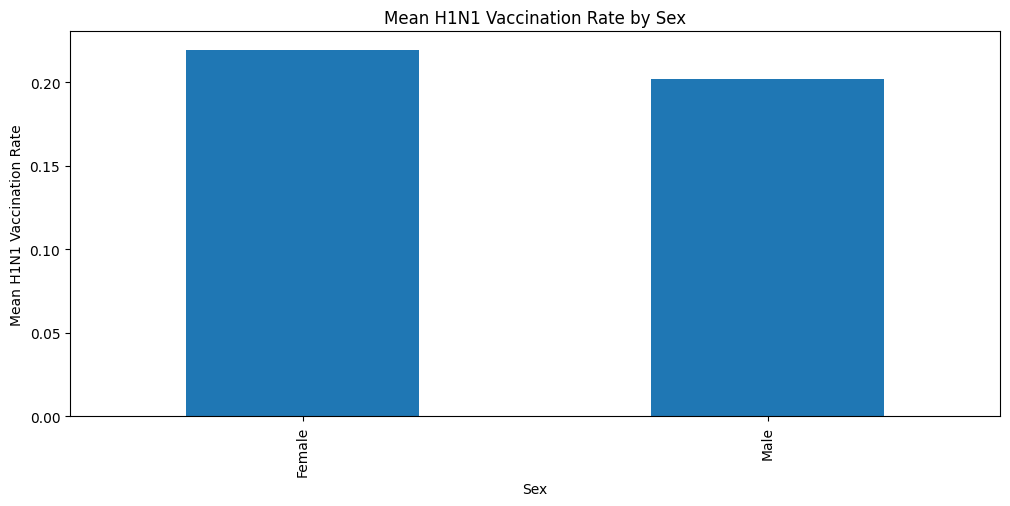

In [43]:
fix, ax = plt.subplots(figsize=(12,5))
vaccines_demo.groupby("sex")['h1n1_vaccine'].mean().plot(kind='bar', ax=ax)
plt.xlabel('Sex') # Add x-axis label
plt.ylabel('Mean H1N1 Vaccination Rate') # Add y-axis label
plt.title('Mean H1N1 Vaccination Rate by Sex') # Add title
plt.show()

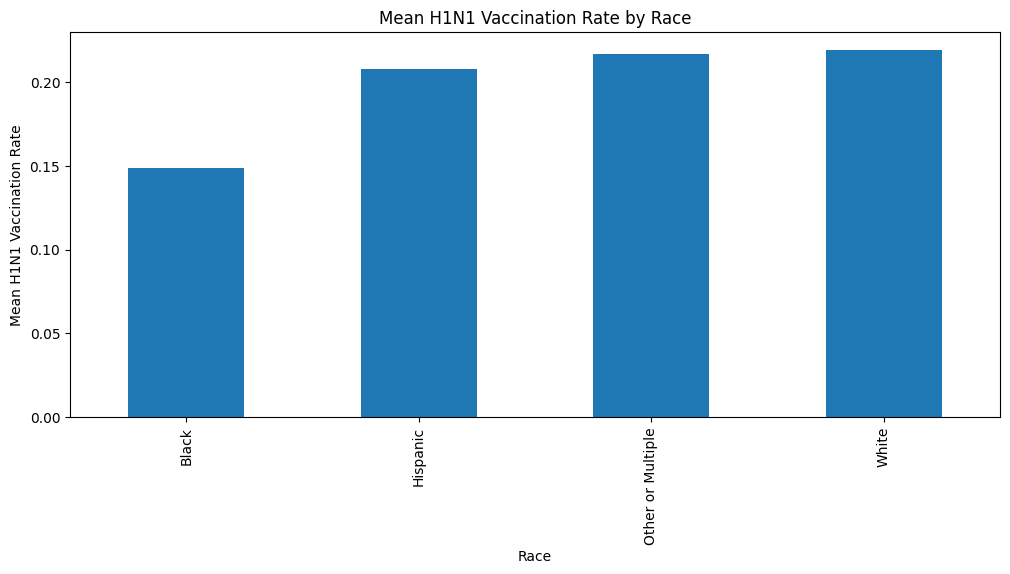

In [44]:
fix, ax = plt.subplots(figsize=(12,5))
vaccines_demo.groupby("race")['h1n1_vaccine'].mean().plot(kind='bar', ax=ax)
plt.xlabel('Race') # Add x-axis label
plt.ylabel('Mean H1N1 Vaccination Rate') # Add y-axis label
plt.title('Mean H1N1 Vaccination Rate by Race') # Add title
plt.show()

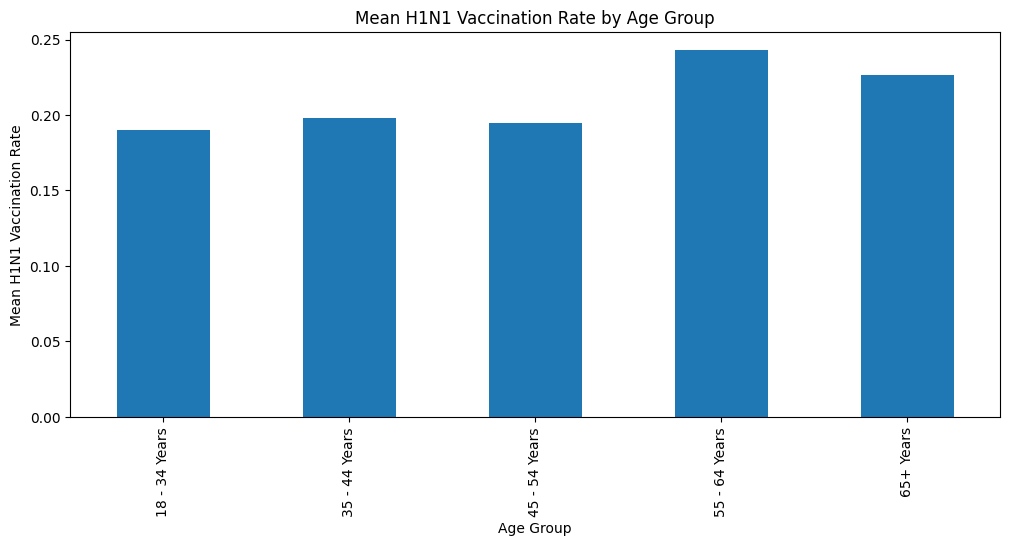

In [45]:
fix, ax = plt.subplots(figsize=(12,5))
vaccines_demo.groupby("age_group")['h1n1_vaccine'].mean().plot(kind='bar', ax=ax)
plt.xlabel('Age Group') # Add x-axis label
plt.ylabel('Mean H1N1 Vaccination Rate') # Add y-axis label
plt.title('Mean H1N1 Vaccination Rate by Age Group') # Add title
plt.show()

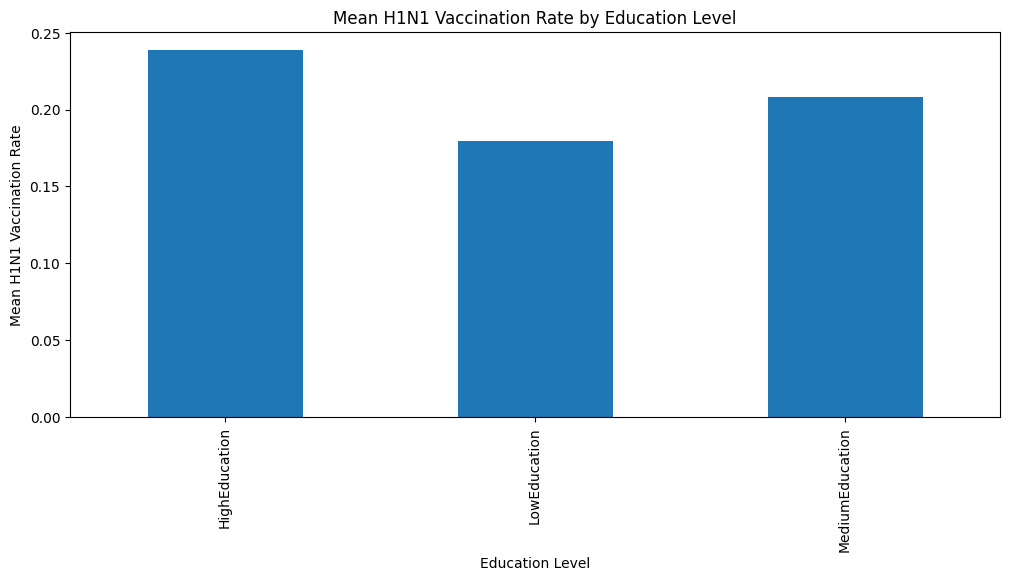

In [46]:
fix, ax = plt.subplots(figsize=(12,5))
vaccines_demo.groupby("education")['h1n1_vaccine'].mean().plot(kind='bar', ax=ax)
plt.xlabel('Education Level') # Add x-axis label
plt.ylabel('Mean H1N1 Vaccination Rate') # Add y-axis label
plt.title('Mean H1N1 Vaccination Rate by Education Level') # Add title
plt.show()

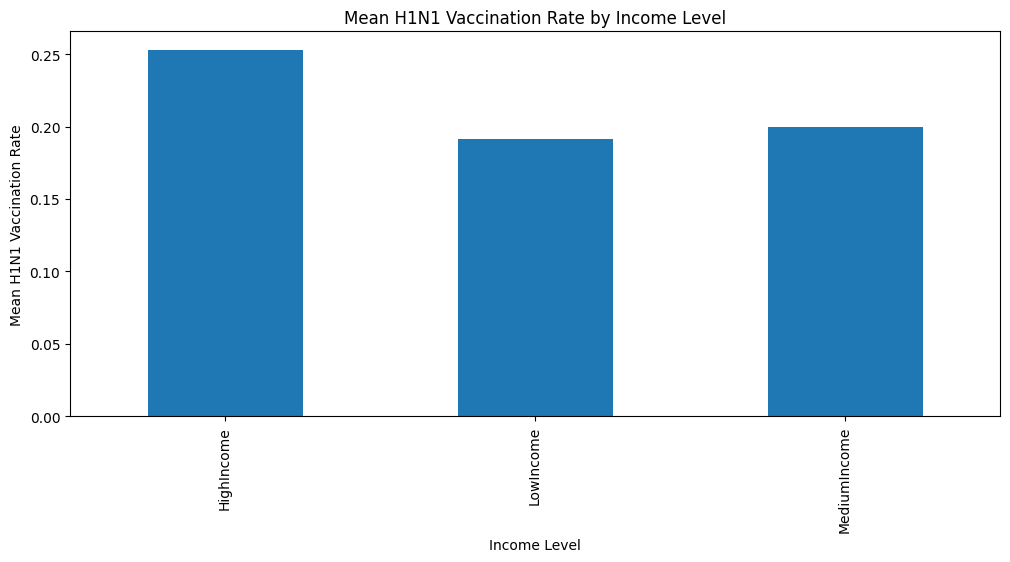

In [47]:
fix, ax = plt.subplots(figsize=(12,5))
vaccines_demo.groupby("income_poverty")['h1n1_vaccine'].mean().plot(kind='bar', ax=ax)
plt.xlabel('Income Level') # Add x-axis label
plt.ylabel('Mean H1N1 Vaccination Rate') # Add y-axis label
plt.title('Mean H1N1 Vaccination Rate by Income Level') # Add title
plt.show()

# Data Modeling

In [48]:
vaccines_demo = pd.get_dummies(vaccines_demo,columns=['age_group','education','income_poverty','sex','race'],drop_first=True,dtype=int)

In [49]:
vaccines_all = pd.merge(vaccines_demo, vaccines_behavior,on='respondent_id',how='inner')
vaccines_all.head()

,respondent_id,h1n1_vaccine_x,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_LowEducation,education_MediumEducation,income_poverty_LowIncome,income_poverty_MediumIncome,...,race_Other or Multiple,race_White,h1n1_vaccine_y,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face
0,0,0,0,0,1,0,1,0,1,0,...,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1,0,1,0,0,0,1,0,1,0,...,0,1,0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
2,2,0,0,0,0,0,0,0,0,1,...,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,0,1,1,0,1,0,...,0,1,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,4,0,0,1,0,0,0,1,0,1,...,0,1,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0


In [50]:
vaccines_demo = vaccines_demo.drop(['respondent_id'],axis=1)

correlation_maxtrix_vaccines_demo = vaccines_demo.corr()['h1n1_vaccine']
print(correlation_maxtrix_vaccines_demo)

h1n1_vaccine                   1.000000
age_group_35 - 44 Years       -0.014733
age_group_45 - 54 Years       -0.021401
age_group_55 - 64 Years        0.038122
age_group_65+ Years            0.020377
education_LowEducation        -0.053183
education_MediumEducation     -0.006712
income_poverty_LowIncome      -0.017313
income_poverty_MediumIncome   -0.041907
sex_Male                      -0.020672
race_Hispanic                 -0.002902
race_Other or Multiple         0.002508
race_White                     0.030887
Name: h1n1_vaccine, dtype: float64


In [51]:
y = vaccines_demo['h1n1_vaccine']
X = vaccines_demo.drop('h1n1_vaccine', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [52]:
model = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7876291747790924
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      5260
           1       0.00      0.00      0.00      1417

    accuracy                           0.79      6677
   macro avg       0.39      0.50      0.44      6677
weighted avg       0.62      0.79      0.69      6677



In [53]:
cf = confusion_matrix(y_test, y_pred)
print(cf)

[[5259    1]
 [1417    0]]


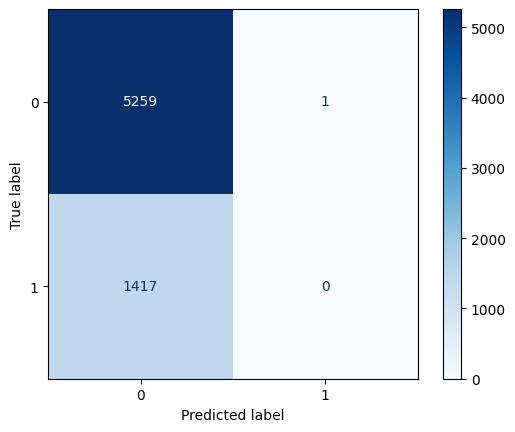

In [54]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.show()

In [55]:
over = RandomOverSampler(sampling_strategy=0.7)
X_over, y_over = over.fit_resample(X_train, y_train)

model = LogisticRegression(fit_intercept=False, C=1e12, solver='lbfgs')
model.fit(X_over, y_over)

y_pred_over = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_over)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_over))

Accuracy: 0.7542309420398382
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      5260
           1       0.31      0.13      0.18      1417

    accuracy                           0.75      6677
   macro avg       0.55      0.52      0.52      6677
weighted avg       0.69      0.75      0.71      6677



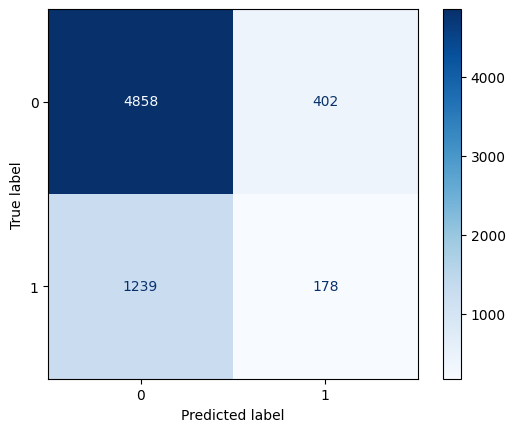

In [56]:
cf_over = confusion_matrix(y_test, y_pred_over)
disp_over = ConfusionMatrixDisplay(confusion_matrix=cf_over, display_labels=model.classes_)
disp_over.plot(cmap='Blues')
plt.show()

In [57]:
print("Original data shape:", X_train.shape)
print("Original target distribution:", np.bincount(y_train))
print("Resampled data shape:", X_over.shape)
print("Resampled target distribution:", np.bincount(y_over))

Original data shape: (20030, 12)
Original target distribution: [15773  4257]
Resampled data shape: (26814, 12)
Resampled target distribution: [15773 11041]


## Evaluation

In [58]:
X_train_sm = sm.add_constant(X_train)
logit_model=sm.Logit(y_train,X_train_sm)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.511644
         Iterations 6
                               Results: Logit
Model:                   Logit               Method:              MLE       
Dependent Variable:      h1n1_vaccine        Pseudo R-squared:    0.011     
Date:                    2025-06-06 02:26    AIC:                 20522.4738
No. Observations:        20030               BIC:                 20625.2386
Df Model:                12                  Log-Likelihood:      -10248.   
Df Residuals:            20017               LL-Null:             -10361.   
Converged:               1.0000              LLR p-value:         1.2232e-41
No. Iterations:          6.0000              Scale:               1.0000    
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
const

The logistic regression results indicate that several factors are significantly associated with H1N1 vaccination status. Specifically, individuals in older age groups (ages 55-64 and age 65+) are more likely to be vaccinated.  Those falling in the categories of low eduction and low or medium income are less likely to be vaccinated.  Men are predicted to recieve a vaccination less often than women and hispanic or other races are more likely to be vaccinated.

# Conclusion

The goal of the public health campaign is to reach those demographics who are less likely to vaccinate and convince as many of them as possible to vaccinate to reduce the spread of H2N2 through "herd immunity".  To reach those demographics, we have the following recommendations:

*   **Make it Convenient** People in younger age groups tend to have busy schedules with jobs, children to care for, etc. To help them out, offer mobile vaccination clinics where younger people frequent - schools, gyms, parks. And keep the process simple.
*  **Reduce Cost** With the lower income groups being less likely to recieve a vaccination, make sure the cost is low or free, so that financial problems are not the reason they aren't protected with vaccines.
*   **Educate** Low education levels tend to have less vaccinations.  Make sure a lower education doesn't prevent them from having the same low education on vaccinations.  Give them a chance to learn the concept of a vaccine, address misinformation that exists (we do not inject live, active viruses!), provide risk and reward.  Make sure information is clear and concise.


## Limitations

A limitation of the H1N1 data from United States National Center for Health Statistics is that it is surveyed data.  The data depends on the responses of a participant and that's if they answer at all.  We assume here that the likelihood of a participant responding to the survey is uniformly distributed.